# Importing Libraries

In [1]:
#!pip install keras
#!pip install tensorflow
#!pip install spacy
import numpy as np
import pandas as pd
import csv
import keras
import sklearn
import random
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
import io
import string
#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS
#from spacy.lang.en import English
#import en_core_web_sm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import seaborn as sns

Using TensorFlow backend.


# Data Exploration

In [2]:

print ("Reading text data for classification and building representations...")
df = pd.read_excel ("C:\\Users\\v-savrav\\Text\\data\\datasetv1.xlsx")

Reading text data for classification and building representations...


In [3]:
df.columns

Index(['PrimaryTopic', 'secondarytopic', 'Description'], dtype='object')

# Input: 'Description'
# Output :'PrimaryTopic'

In [4]:
df['secondarytopic'].value_counts()

Invoice Payment Status                                 20215
Email Invoice and Refund Submission                    11801
Others                                                  5349
Expense Report Submission Query                         4580
Travel and Expenses Status                              3521
SAP Flow                                                3496
Payment Action                                          2793
Education on Vendor, Categories and Process             2708
Audit and Policy Violation Notification                 2545
User Education on Tool and Process                      2508
Invoice Change Request                                  2488
Employee Account Maintenance and Status Query           2451
Reporting Request                                       2319
MPC - Payee Account Maintenance                         1898
Bank                                                    1818
Statement of Account Request                            1304
Other Actions SAP       

In [5]:
vc=df['secondarytopic'].value_counts()
u  = [i not in set(vc[vc<1000].index) for i in df['secondarytopic']]
df = df[u]


# Removing NULL records

In [6]:
from io import StringIO
df = df[pd.notnull(df['Description'])]
df = df[pd.notnull(df['secondarytopic'])]

In [7]:
df

,PrimaryTopic,secondarytopic,Description
2,AP Reporting Request,Reporting Request,"PO re-opened Hi Team, Kindly note that PO 009..."
6,Payee Account Management,Employee Account Maintenance and Status Query,"Hello Prohelp, Please send the DOCUSIGN link ..."
7,Invoice Management,Invoice Payment Status,"Hola, Se puede usar la tarjeta de MS para p..."
8,Invoice Management,Invoice Payment Status,Talebiniz bize ulasti Degerli Müsterimiz...
9,Invoice Management,Statement of Account Request,QVR 1086 - Austria
11,Disbursement,Payment Action,"Hi Team, Please note thatBangladesh bank file..."
12,Payee Account Management,Employee Account Maintenance and Status Query,"Hello AP Team, Based on the below supplier unb..."
14,MyOrder Requisition Request,PO Status Request,Asked for an approval
15,Invoice Management,Invoice Payment Status,"Hi Team, Good day! We have resubmitted the b..."
16,Invoice Management,Statement of Account Request,Accounts Payable Reconciliation - 2297780 - Pr...


# Factorising the Primary Topic to ID

In [8]:
df['id'] = df['secondarytopic'].factorize()[0]
category_id_df = df[['secondarytopic', 'id']].drop_duplicates().sort_values('id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['id', 'secondarytopic']].values)
df.head()

,PrimaryTopic,secondarytopic,Description,id
2,AP Reporting Request,Reporting Request,"PO re-opened Hi Team, Kindly note that PO 009...",0
6,Payee Account Management,Employee Account Maintenance and Status Query,"Hello Prohelp, Please send the DOCUSIGN link ...",1
7,Invoice Management,Invoice Payment Status,"Hola, Se puede usar la tarjeta de MS para p...",2
8,Invoice Management,Invoice Payment Status,Talebiniz bize ulasti Degerli Müsterimiz...,2
9,Invoice Management,Statement of Account Request,QVR 1086 - Austria,3


In [9]:
df['id'].value_counts()

2     19989
10    11643
9      5332
11     4023
7      3449
6      3291
4      2779
17     2642
8      2542
13     2447
1      2393
14     2320
0      2255
15     1876
18     1817
3      1291
16     1153
12     1084
5      1020
Name: id, dtype: int64

# Imbalanced Classes
We see that the number of complaints per product is imbalanced. Consumers’ complaints are more biased towards 
Invoice Management, Payee Account Management and Travel and Expenses Management.


However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy
for the minority classes. Therefore, we will leave it as it is.

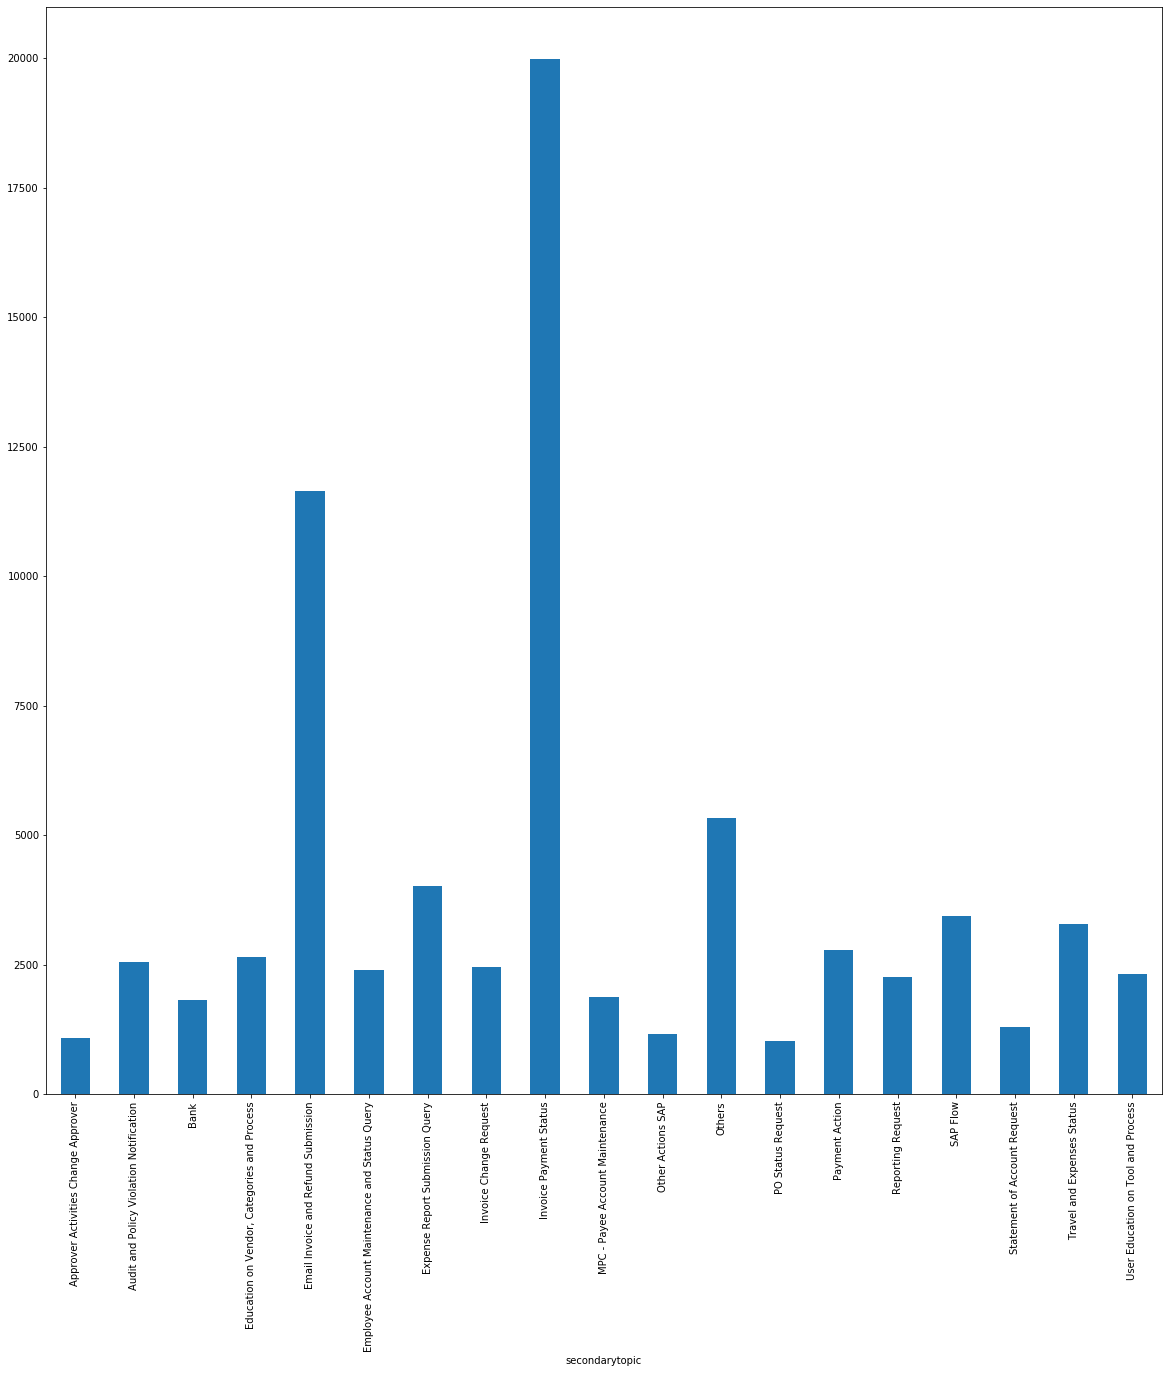

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
df.groupby('secondarytopic').Description.count().plot.bar(ylim=0)
plt.show()

In [11]:
from transformers import AdamW

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#is based on The Porter Stemming Algorithm
stopwords = stopwords.words("english")
snowball_stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
df=df.dropna()
df['Description']=df['Description'].astype(str)
df=df.reset_index()
# tokenization 
tokenized_doc = df['Description'].apply(lambda x: x.split())

# remove stop-words 

tokenized_doc = tokenized_doc.apply(lambda x: [wordnet_lemmatizer.lemmatize(item) for item in x if item not in stopwords])
#tokenized_doc = tokenized_doc.apply(lambda x: [snowball_stemmer.stem(item) for item in x ])
# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

df['Description'] = detokenized_doc

In [14]:
import string

def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

df['Description'] = df['Description'].apply(remove_punctuation)

# Text Representation

In [31]:
from sklearn.feature_extraction.text import HashingVectorizer
vector = HashingVectorizer(decode_error = 'ignore',
                          n_features = 2**21,
                          preprocessor = None,
                           encoding='utf-8',lowercase=True, ngram_range=(1,1))

In [32]:
X = vector.fit_transform(df['Description'])
print(X.shape)
labels = df.id

(73346, 2097152)


In [17]:
df['Description'][1]

'Hello Prohelp Please send DOCUSIGN link EE NAME  EMPLOYEE  Hi Simas When Prohelp sends link form please complete field boxed RED field required update employee expense reimbursement account accurately In addition please use Bolded reply related field form  Company code employee set extended  1010  Is request relocation reimbursement MGR reimbursements  Relocation  If relocation relocation contact Zhiqingsheenatancartuscom  For relocation reimbursements currency request paid in Please mention currency code wish reimbursed  If IBAN number not bank do please add bank field section DocuSign form  Ensure Employee ID correct Thank you Warmest Regards Sheena OUT OF OFFICE SCHEDULE Office Closure 28 Oct Mon lieu Deepavali public holiday Personal Leave 29 30 31 Oct Tue Wed Thu  Sheena Tan Senior ConsultantCartus 4 Shenton Way 1601 SGX Centre 2 Singapore 068807 ZhiQingSheenaTanCartuscom Tel 65 6880 4167 Ext 2594  Fax 65 6557 0071 Company Registration No 200002346K  CEA License No L3010655E Conn

In [18]:
df=df[['id','Description','secondarytopic']]

In [27]:
X=df['Description']
y=df['id']

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.30, random_state=0)


In [26]:
X_train

1373     Hi I finally registered Microsoft Azure If sub...
61954                                           7601920740
61790    Dear Sir  Madam Please find document attached ...
36038    Hi Steve Thanks Got it Since warehouse moved D...
64783    Hi If line item remaining PO dated fiscal year...
55335    Hi Team Please help post HK MEWB FY18 P12 shar...
16579    po status request Hi Saranya Rajasekar Could p...
12882    Dear ACCOUNTS PAYABLE Please find attached cre...
61012                                 IO PO status updated
13945    Hello INR 2000 part cash payment credited acco...
13601    Your message could posted Yammer You send mess...
46411    Hi Dinesh  Raghu Could please check whether am...
60073    Hi Jan Accounts Payable Please find attached i...
41786    Hi Janine Amy I looked one appears amount 2043...
60312    Hi AP AU Can please explain PO reflecting OPEN...
62367    Informed reflected P2P support tool Dear Team ...
17884    Estimadas Agradeceré puedan dar una fecha de p.

In [19]:
import os
import sys
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
import scrapbook as sb
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
#from utils_nlp.common.timer import Timer
#from utils_nlp.dataset.multinli import load_pandas_df
#from utils_nlp.models.transformers.sequence_classification import (
#    Processor, SequenceClassifier)

In [15]:
def tweetGenerator(df):
    """
    This function takes a tweet from the data frame
    and returns the text of the tweet as well as the sentiment label
    """
    for row in df.itertuples():
        label = row[1]
        tweet = row[2]
        yield tweet, label

In [16]:
tweet_gen = tweetGenerator(df)

In [17]:
def getBatch(tweet_gen, size):
    """
    This function takes as arguments
    the tweet generator tweet_gen and the batch size
    desired. It returns two lists for the tweets and labels
    whose length is the batch size
    """
    tweets, labels = [], []
    for _ in range(size):
        tweet, label = next(tweet_gen)
        tweets.append(tweet)
        labels.append(label)
    return tweets, labels

In [20]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(loss='hinge', alpha=1e-4, shuffle=True)

In [21]:
from sklearn.linear_model import SGDClassifier
SGDclassifier = SGDClassifier(loss='hinge', alpha=1e-4, shuffle=True, random_state=1)
tweet_gen = tweetGenerator(df)

In [28]:
import pyprind
batchSize = 5000
totalTweets = len(df)
#totalTweets = 15000
iterations = int(totalTweets/batchSize)
progressBar = pyprind.ProgBar(iterations)

classes = np.unique(y)


In [29]:
len(df['id'].value_counts())

19

In [33]:
for i in range(iterations):
    X_train, y_train = getBatch(tweet_gen, size=batchSize)
    X_train = vector.transform(X_train)
    #SGDclassifier.partial_fit(X_train, y_train, classes=classes)
    clf.partial_fit(X_train, y_train, classes=classes)   
    progressBar.update()

ValueError: classes should include all valid labels that can be in y

In [28]:
#tweet_gen_test = tweetGenerator(df_test)
#X_test, y_test = getBatchTest(tweet_gen_test, size=df_test.shape[0])
X_test = vector.transform(X_test)

In [29]:
X_train.shape

(5000, 2097152)

In [30]:
X_test.shape

(22004, 2097152)

In [31]:
print('Accuracy: %.3f' %  clf.score(X_test, y_test))

Accuracy: 0.666


# Prediction 

# Confusion Matrix
   The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications,and it might be interesting to see what those are caused by:

In [ ]:
filename = 'clf_model.sav'
joblib.dump(clf, filename)

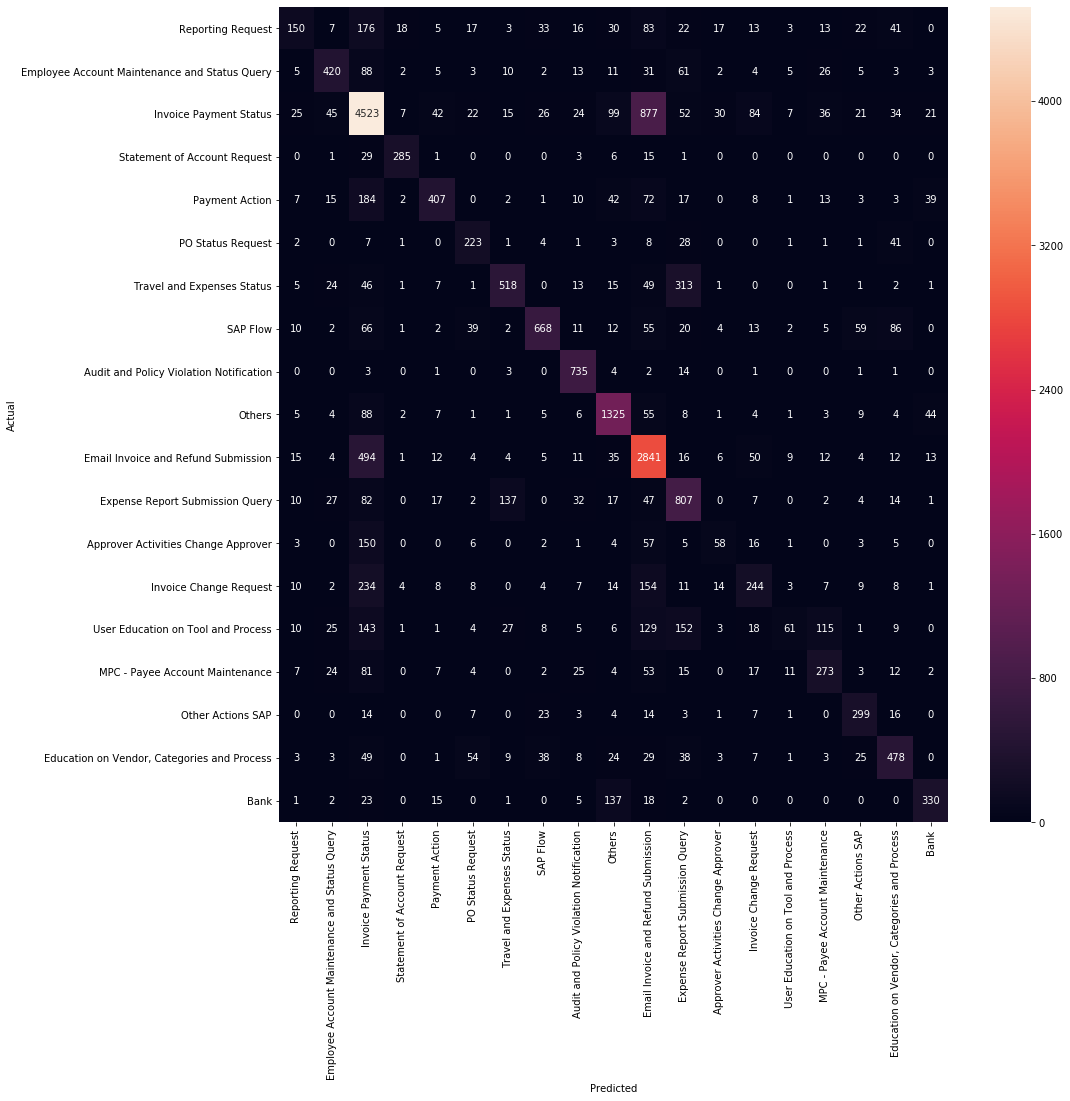

In [32]:
#model = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
#model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.secondarytopic.values, yticklabels=category_id_df.secondarytopic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# clf report

In [33]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['secondarytopic'].unique()))

                                               precision    recall  f1-score   support

                            Reporting Request       0.56      0.22      0.32       669
Employee Account Maintenance and Status Query       0.69      0.60      0.64       699
                       Invoice Payment Status       0.70      0.76      0.73      5990
                 Statement of Account Request       0.88      0.84      0.86       341
                               Payment Action       0.76      0.49      0.60       826
                            PO Status Request       0.56      0.69      0.62       322
                   Travel and Expenses Status       0.71      0.52      0.60       998
                                     SAP Flow       0.81      0.63      0.71      1057
      Audit and Policy Violation Notification       0.79      0.96      0.87       765
                                       Others       0.74      0.84      0.79      1573
          Email Invoice and Refund Submiss

In [35]:
from sklearn.externals import joblib
filename = 'clf_model.sav'
joblib.dump(clf, filename)

C:\Users\v-savrav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['clf_model.sav']